In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
torch.cuda.is_available(), torch.backends.cudnn.enabled

(True, True)

In [4]:
PATH='/home/sean/data/ISIC2018/'

fn='ISIC2018_Task3_Training_LesionGroupings'
fn2='ISIC2018_Task3_Training_GroundTruth'
train_csv = f'{PATH}train.csv'

In [40]:
gt = pd.read_csv(f'{PATH}{fn2}.csv')


(10015, 8)

In [21]:
lg = pd.read_csv(f'{PATH}{fn}.csv')
lg.head()

,image,lesion_id,diagnosis_confirm_type
0,ISIC_0024306,HAM_0000550,serial imaging showing no change
1,ISIC_0024307,HAM_0003577,serial imaging showing no change
2,ISIC_0024308,HAM_0001477,serial imaging showing no change
3,ISIC_0024309,HAM_0000484,serial imaging showing no change
4,ISIC_0024310,HAM_0003350,histopathology


## Pandas Ground Truth Formatting

In [8]:
# gt.loc[:,'MEL':'VASC'].replace(1, pd.Series(gt.columns, gt.columns));

In [22]:
cats = list(gt.columns.values)[1:]
len(gt[cats])

10015

In [77]:
df = gt.copy()
df[cats] = df.loc[:,'MEL':'VASC'].replace(1, pd.Series(df.columns, df.columns));
nonzero_indexs = df[cats].apply(np.nonzero,axis=0)
nonzero_indexs.index
nonzero_indexs['MEL'][0]

array([    4,     7,     9, ..., 10007, 10010, 10011])

In [94]:
df['class'] = np.nan
for c in cats:
    print('adding %s to class' % c)
    df.loc[nonzero_indexs[c][0], 'class'] = c
df.head()

adding MEL to class
adding NV to class
adding BCC to class
adding AKIEC to class
adding BKL to class
adding DF to class
adding VASC to class


,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,class
0,ISIC_0024306,0,NV,0,0,0,0,0,NV
1,ISIC_0024307,0,NV,0,0,0,0,0,NV
2,ISIC_0024308,0,NV,0,0,0,0,0,NV
3,ISIC_0024309,0,NV,0,0,0,0,0,NV
4,ISIC_0024310,MEL,0,0,0,0,0,0,MEL


In [131]:
list(df['image'])[0]

'ISIC_0024306'

NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: class, dtype: int64


(<matplotlib.axes._subplots.AxesSubplot at 0x7f56cc49cc88>,
 '/home/sean/data/ISIC2018/train.csv')

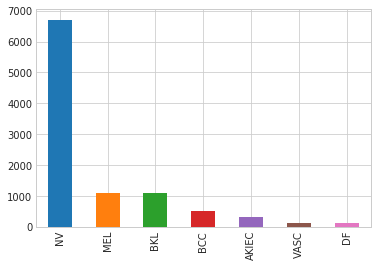

In [46]:
# tdf = pd.DataFrame(list(df['class']), index=list(df['image']), columns=['class'])
# tdf.to_csv(train_csv)
tdf = pd.read_csv(train_csv)
tdf.columns = ['image', 'class']
print(tdf['class'].value_counts())
tdf['class'].value_counts().plot(kind='bar'), train_csv

In [45]:
tdf.head()

,image,class
0,ISIC_0024306,NV
1,ISIC_0024307,NV
2,ISIC_0024308,NV
3,ISIC_0024309,NV
4,ISIC_0024310,MEL


## Data Loader for Training

In [5]:
def rand_by_mask(mask, preds, mpl=4): return np.random.choice(np.where(mask)[0], min(len(preds), mpl), replace=False)
def rand_by_correct(is_correct, preds, val_y): return rand_by_mask((preds == val_y)==is_correct, preds)
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

In [6]:
# The network architecture to use, resnet34 is a good start, will get better performance with resnext50 or inceptionv4
arch=resnet34
# image size
sz=224

# Dataset augmentations
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down)
# The dataloader, used for training and evaluation, has numerous useful functions for:
# loading data, preprocessing, batching, obtaining basic stats, and more
data = ImageClassifierData.from_csv(PATH, 'Task3_Training_Input', train_csv, tfms=tfms,
                    suffix='.jpg')

In [7]:
data.classes

['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

In [8]:
f_cls_n = ['Actinic_keratosis', 'Basal cell carcinoma', 'Benign keratosis', 
                    'Dermatofibroma', 'Melanoma', 'Melanocytic nevus', 'Vascular lesion']
clids = np.arange(len(data.classes))
f_cls_n = [ss.replace(' ', '_') for ss in f_cls_n]
cls2fn = {k: v for (k, v) in zip(data.classes, f_cls_n)}
id2cls = {k: v for (k,v) in zip(clids, data.classes)}
id2fn = {k:v for (k,v) in zip(clids, f_cls_n)}
cls2id = {k:v for (k,v) in zip(data.classes, clids)}
cls2fn, '  ', id2cls, '  ', id2fn, ' ', cls2id

({'AKIEC': 'Actinic_keratosis',
  'BCC': 'Basal_cell_carcinoma',
  'BKL': 'Benign_keratosis',
  'DF': 'Dermatofibroma',
  'MEL': 'Melanoma',
  'NV': 'Melanocytic_nevus',
  'VASC': 'Vascular_lesion'},
 '  ',
 {0: 'AKIEC', 1: 'BCC', 2: 'BKL', 3: 'DF', 4: 'MEL', 5: 'NV', 6: 'VASC'},
 '  ',
 {0: 'Actinic_keratosis',
  1: 'Basal_cell_carcinoma',
  2: 'Benign_keratosis',
  3: 'Dermatofibroma',
  4: 'Melanoma',
  5: 'Melanocytic_nevus',
  6: 'Vascular_lesion'},
 ' ',
 {'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6})

Show images from the different classes

In [9]:
def sample_ims(c, ys=data.trn_y, ds=data.trn_ds, numimgs=9, figsize=(24,12)):
    idm = rand_by_mask(c == ys, ys, mpl=numimgs)
    ims = [load_img_id(ds, i) for i in idm]
    r = np.ceil(len(ims) / 3).astype(int)
    tt = 'Sample {} ({}) images (class id={}, {} total)'.format(id2fn[c], id2cls[c], c, np.sum(c==ys))
    plots(ims, figsize=figsize, rows=r, titles=["Id: {}".format(i) for i in idm])
    plt.suptitle(tt, fontsize=24)


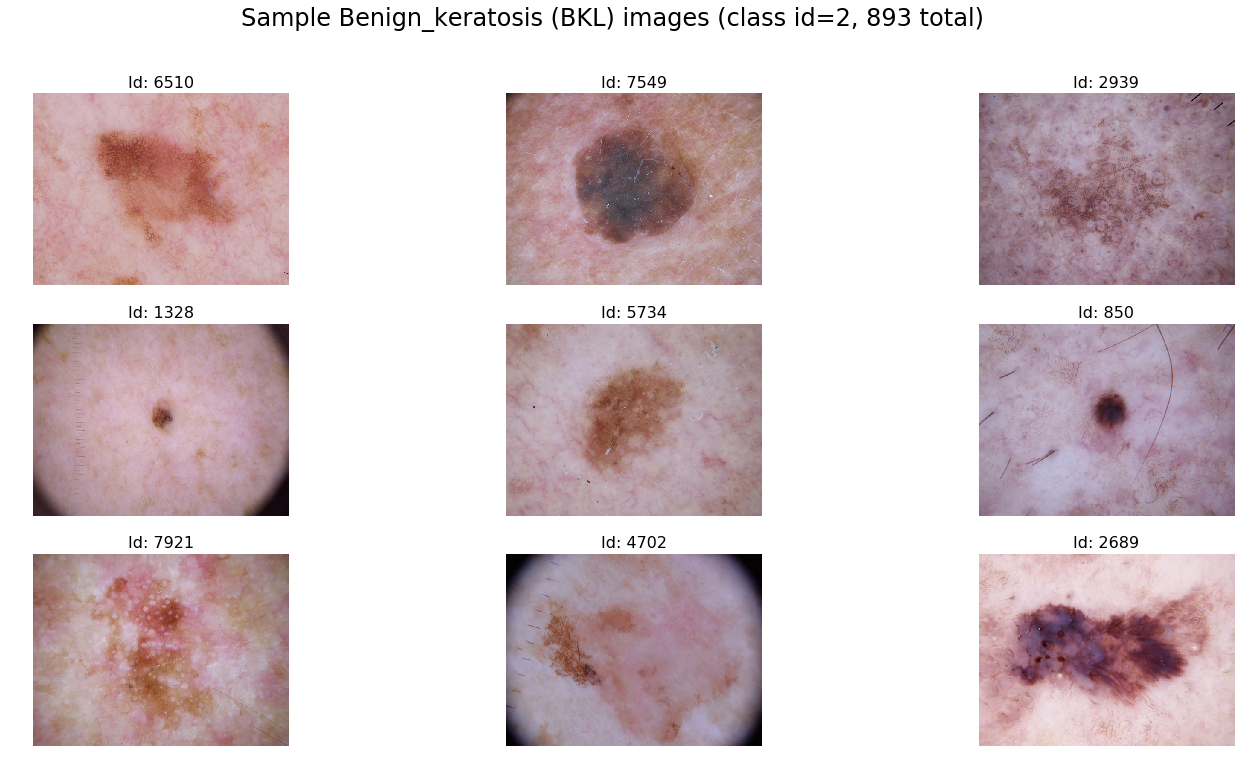

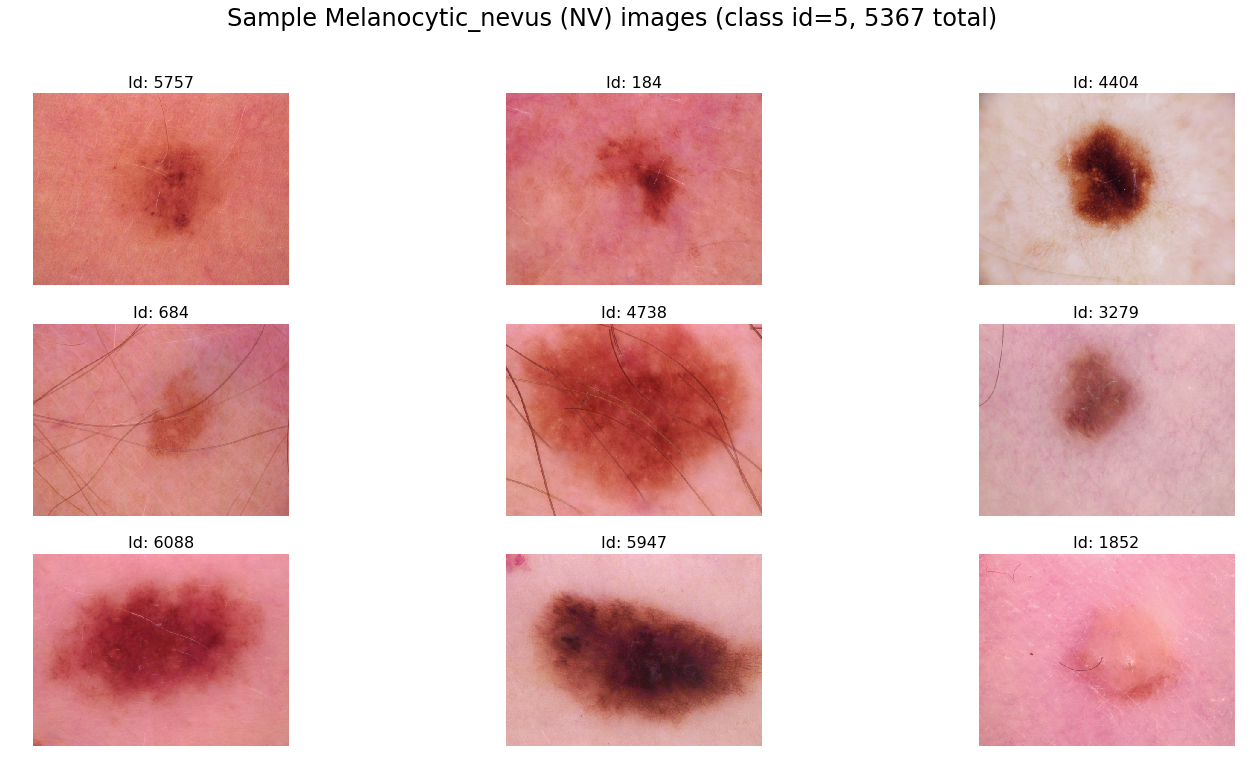

In [10]:
# for i in range(min(len(data.classes),10)): sample_ims(i)
sample_ims(2)
sample_ims(5)

In [11]:
data.trn_ds.n

8012

In [12]:
data.val_ds.n

2003

In [13]:
x,y = next(iter(data.val_dl))

In [14]:
x[0].shape

torch.Size([3, 224, 224])

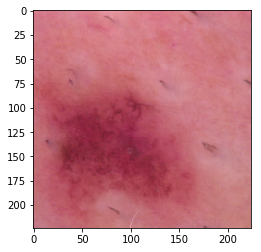

In [15]:
plt.imshow(data.val_ds.denorm(to_np(x))[1])

## Train Model

In [7]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [48]:
lrf=learn.lr_find()
# learn.sched.plot_lr()

 81%|████████  | 102/126 [00:00<00:00, 191.11it/s, loss=1.77]


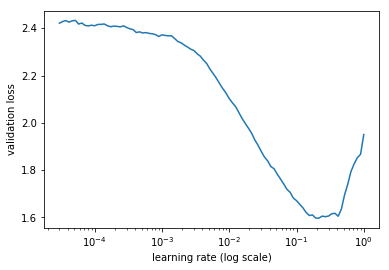

In [13]:
learn.sched.plot()

In [14]:
learn.fit(0.03, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      0.932018   0.746777   0.736895  
    1      0.806457   0.677628   0.75337                     



[array([0.67763]), 0.7533699451418918]

In [99]:
learn.fit(0.01, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      0.666123   0.62425    0.767848  
    1      0.625807   0.609197   0.770344                    
    2      0.625448   0.60297    0.777833                    
    3      0.604542   0.601088   0.77983                     
    4      0.584654   0.591306   0.78682                     



[array([0.59131]), 0.7868197704039986]

In [118]:
learn.save('224_pre')

In [8]:
learn.load('224_pre')

## Visualisation

In [18]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct, preds, val_y): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == val_y)==is_correct) & (val_y == y), mult)

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    p_str = '{}\nGT: {}\nPred: {}'
    title_probs = [p_str.format(round(probs[x],2), f_cls_n[data.val_y[x]], f_cls_n[preds[x]]) for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

In [19]:
log_preds = learn.predict()
log_preds.shape

(2003, 7)

In [20]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
# probs = np.exp(log_preds[:,1]) 
probs = np.exp(log_preds[np.arange(log_preds.shape[0]), preds])

In [21]:
preds[0:10]

array([5, 5, 5, 5, 3, 5, 5, 5, 5, 2])

In [22]:
preds.shape

(2003,)

Correctly classified


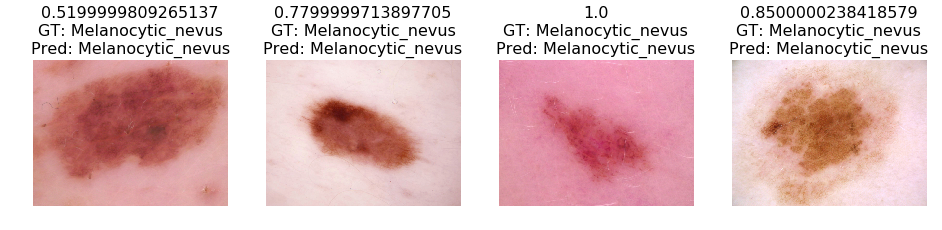

In [23]:
plot_val_with_title(rand_by_correct(True, preds, data.val_y), "Correctly classified")

Incorrectly classified


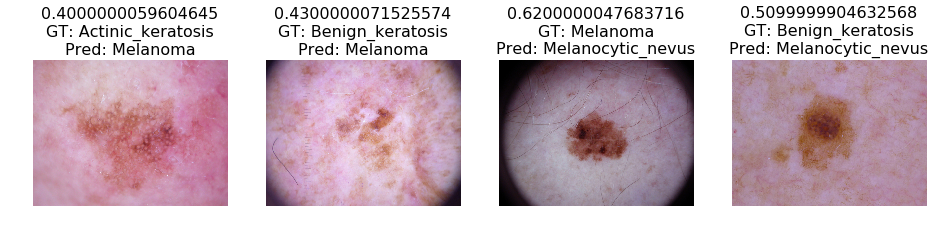

In [24]:
# A few incorrect labels at random
plot_val_with_title(rand_by_correct(False, preds, data.val_y), "Incorrectly classified")

Most correct Melanocytic_nevus


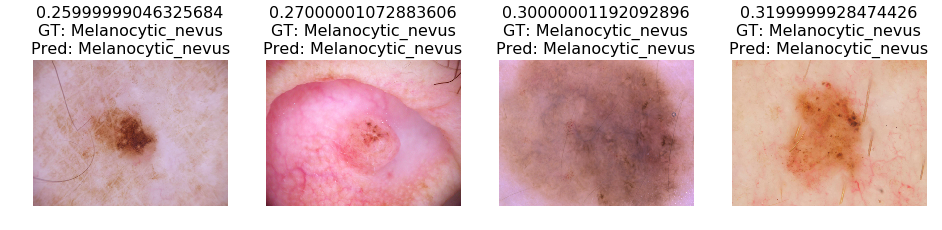

In [25]:
cls = 5
plot_val_with_title(most_by_correct(cls, True, preds, data.val_y), "Most correct {}".format(f_cls_n[cls]))

Most correct Melanoma


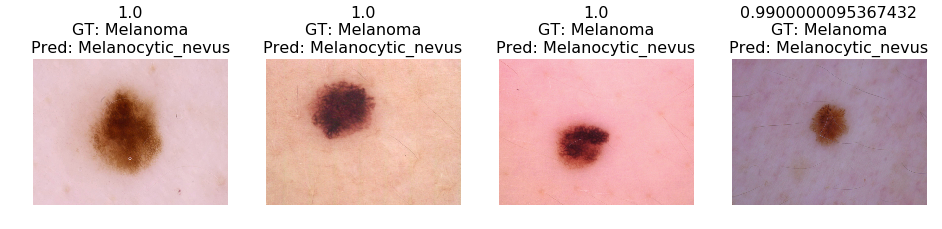

In [26]:
cls = 4
plot_val_with_title(most_by_correct(cls, False, preds, data.val_y), "Most correct {}".format(f_cls_n[cls]))

## Accuracy on Validation Set

In [14]:
import sklearn.metrics as metrics
from fastai.plots import plot_confusion_matrix

In [28]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [29]:
mprobs = np.exp(multi_preds)

In [30]:
len(y), y.shape, np.unique(y)

(2003, (2003,), array([0, 1, 2, 3, 4, 5, 6]))

In [111]:
y[0:5]

array([5, 5, 5, 5, 3])

In [112]:
preds[0,:]

array([-6.52844, -7.61679, -4.49021, -6.08692, -3.80471, -0.03854, -9.25039], dtype=float32)

In [31]:
final_preds = np.argmax(preds, 1).squeeze()
# final_preds[50] = 3
final_preds[0:10], final_preds.shape, np.unique(final_preds)

(array([5, 5, 5, 5, 3, 5, 5, 5, 5, 2]), (2003,), array([0, 1, 2, 3, 4, 5, 6]))

WARNING! Distorting largest value to make confusion matrix easier to read
[[ 24   5  14   0  10   9   0]
 [  6  51  10   1   6  30   2]
 [  4   6 112   0  23  61   0]
 [  1   2   1   2   2  13   1]
 [  5   3  19   0 107 105   0]
 [  4   1  36   0  34 168   2]
 [  1   2   0   0   0   8  19]]


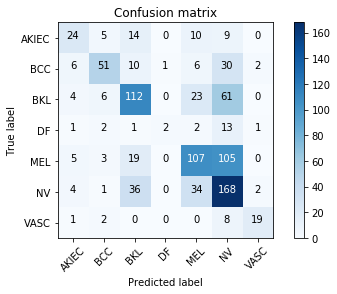

In [32]:
cm = metrics.confusion_matrix(y, final_preds)
print("WARNING! Distorting largest value to make confusion matrix easier to read")
cm[5,5] = 1.5*np.sort(cm.flatten())[-2]
plot_confusion_matrix(cm, data.classes, cmap=plt.cm.Blues)

Text(0.5,1,'Network Predictions Hist on Validation')

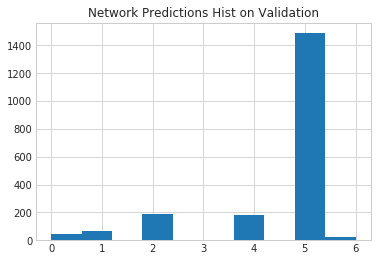

In [33]:
# plt.subplot(1,2,1)
sns.set_style("whitegrid")
plt.hist(final_preds, align='mid');
plt.title('Network Predictions Hist on Validation')
# plt.subplot(1,2,2)
# plt.hist(y)

Text(0.5,1,'GT Validation Hist')

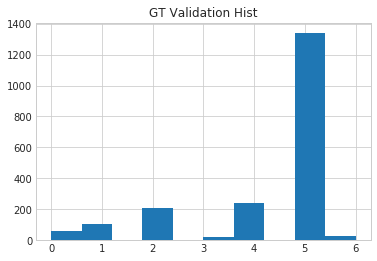

In [34]:
plt.hist(y, align='mid')
plt.title('GT Validation Hist')

Malignant Lesions:

- BCC (but can be benign)
- MEL
- AKIEC (squamous cell carcinoma)

Benign Lesions:
- BKL
- VASC
- NV
- DF

In [35]:
data.classes, cls2fn

(['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'],
 {'AKIEC': 'Actinic_keratosis',
  'BCC': 'Basal_cell_carcinoma',
  'BKL': 'Benign_keratosis',
  'DF': 'Dermatofibroma',
  'MEL': 'Melanoma',
  'NV': 'Melanocytic_nevus',
  'VASC': 'Vascular_lesion'})

In [36]:
mprobs = mprobs.mean(axis=0)
mprobs.shape

(2003, 7)

In [37]:
malids = [cls2id[i] for i in ['BCC', 'MEL', 'AKIEC']]
benids = [cls2id[i] for i in ['BKL', 'VASC', 'NV', 'DF']]
malids, benids

([1, 4, 0], [2, 6, 5, 3])

In [38]:
def classes_bin_roc(cls_ids, y_true, probs, cls_name='Some form of'):
    des_ys = np.array([(y_true == i).astype(int) for i in cls_ids]).sum(0)
    des_ps = probs[:,cls_ids].sum(1)
    # start calculating results bro
    fpr, tpr, _ = metrics.roc_curve(des_ys, des_ps)
    roc_auc = metrics.auc(fpr,tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='AUC (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for {} Skin Cancer Detection'.format(cls_name))
    plt.legend(loc="lower right")
    plt.show()

ROC curves from Stanford paper:
<img src="images/stanford_rocs.png" width="80%">

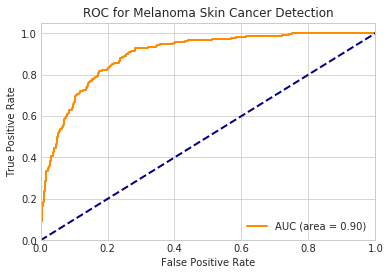

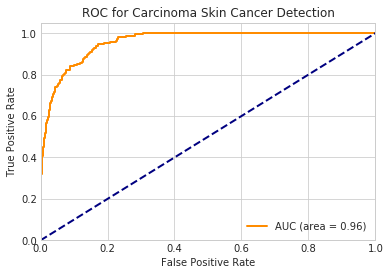

Standford paper reports AUC's ranging from 0.91 - 0.96 on various benchmarks against dermatologists


In [39]:
# classes_bin_roc(malids, y, mprobs, cls_name='Malignant')
classes_bin_roc([cls2id['MEL']], y, mprobs, cls_name='Melanoma')

carcinomas = [cls2id[i] for i in ['BCC', 'AKIEC']]
classes_bin_roc(carcinomas, y, mprobs, cls_name='Carcinoma')

print("Standford paper reports AUC's ranging from 0.91 - 0.96 on various benchmarks against dermatologists")

In [40]:
facc = metrics.accuracy_score(y,final_preds)
print('On my subset of data used in the Stanford paper the validation accuracy is {}.'.format(facc))
print('Stanford paper reports validation accuracies from 0.69-0.72 and 0.48-0.55')

On my subset of data used in the Stanford paper the validation accuracy is 0.7868197703444832.
Stanford paper reports validation accuracies from 0.69-0.72 and 0.48-0.55


Accuracy = 0.79                              
Confusion Matrix:
[[  24    5   14    0   10    9    0]
 [   6   51   10    1    6   30    2]
 [   4    6  112    0   23   61    0]
 [   1    2    1    2    2   13    1]
 [   5    3   19    0  107  105    0]
 [   4    1   36    0   34 1261    2]
 [   1    2    0    0    0    8   19]]
AUC for class 0, id AKIEC = 0.94
----------------------------------------
AUC for class 1, id BCC = 0.97
----------------------------------------
AUC for class 2, id BKL = 0.89
----------------------------------------
AUC for class 3, id DF = 0.96
----------------------------------------
AUC for class 4, id MEL = 0.90
----------------------------------------
AUC for class 5, id NV = 0.93
----------------------------------------
AUC for class 6, id VASC = 0.99
----------------------------------------
[[  24    5   14    0   10    9    0]
 [   6   51   10    1    6   30    2]
 [   4    6  112    0   23   61    0]
 [   1    2    1    2    2   13    1]
 [   5    3 

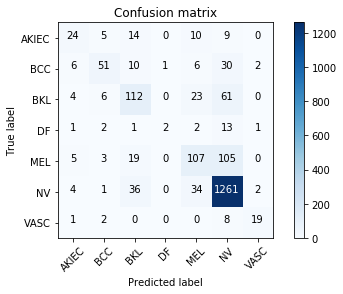

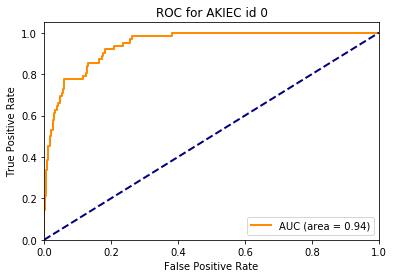

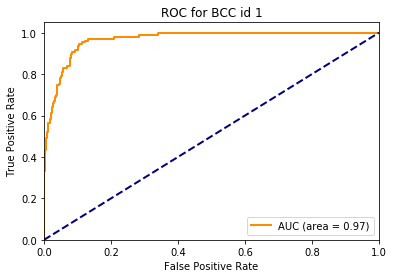

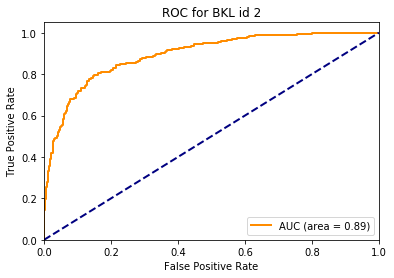

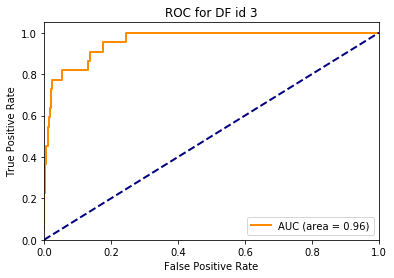

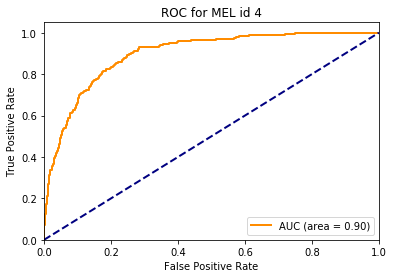

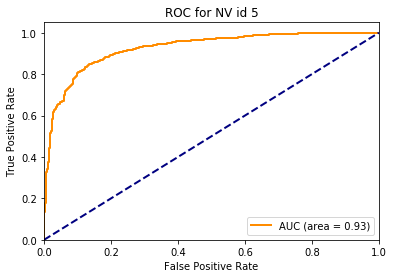

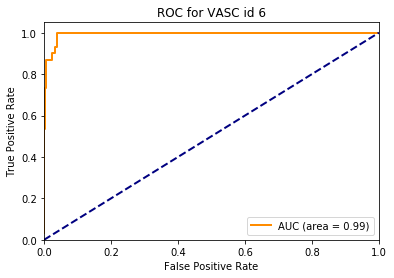

In [15]:
test_csv=''
def load_csv_labels(folder='ISBI2016_ISIC_Part3_Test_Data', csv_=test_csv, s='.jpg'):
    _, y, _ = csv_source(folder, csv_, suffix=s)
    print('Loading ys from csv shape {}; vals {}'.format(y.shape, np.unique(y)))
    return y
    
def run_test(learner, ts=False, test_csv=None):
    '''
    Generate values for printing or plotting the three metrics:
    confusipon matrix (cm)
    ROC curve values
    Accuracy value
    
    Should work for binary and multi-task classification problems
    '''
    log_preds, y = learner.TTA(is_test=ts)
    if ts and np.all(y==0):
        y = load_csv_labels(csv_=test_csv)
    probs = np.exp(log_preds).mean(axis=0) # average of TTA
    final_preds = np.argmax(probs, 1)
    # accuracy
    acc = metrics.accuracy_score(y,final_preds)
    print(f'Accuracy = %0.2f' % acc)
    # confusion matrix
    cm = metrics.confusion_matrix(y, final_preds)
    print(f'Confusion Matrix:\n{cm}')
    # ROC curve values
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(len(learner.data.classes)):
#         set_trace()
        cy = np.array(y == i).astype(int)
        cp = probs[:,i]
        fpr[i], tpr[i], _ = metrics.roc_curve(cy, cp)
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        print('AUC for class {}, id {} = {:0.2f}'.format(i, learner.data.classes[i], roc_auc[i]))
        print('-'*40)
    performance_figs(learner.data.classes, cm, roc_auc, fpr, tpr)
    return log_preds, y, acc, cm, roc_auc, fpr, tpr

def performance_figs(classes, cm, roc_auc, fpr, tpr):
    plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues)
    for i in range(len(classes)):
        plt.figure()
        lw = 2
        plt.plot(fpr[i], tpr[i], color='darkorange',
                 lw=lw, label='AUC (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC for {} id {}'.format(classes[i], i))
        plt.legend(loc="lower right")
        plt.show()
log_preds, y, acc, cm, roc_auc, fpr, tpr = run_test(learn)